In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import optimize
import pandas as pd
from math import factorial

In [2]:
f = pd.read_csv("2020-06-23_18;45;05_PEO_Std_green_01-calibration_june_2020_2-0001.txt", skiprows = 14, delim_whitespace = True)
f = f.stack().str.replace(',','.').unstack()
f["Ret."] = pd.to_numeric(f["Ret."], downcast="float")
f["Vol."] = pd.to_numeric(f["Vol."], downcast="float")
f["RI"] = pd.to_numeric(f["RI"], downcast="float")
f["RALS"] = pd.to_numeric(f["RALS"], downcast="float")
f["LALS"] = pd.to_numeric(f["LALS"], downcast="float")
f["IV"] = pd.to_numeric(f["IV"], downcast="float")
volume = f["Ret."]
ri = f["Vol."]
rals = f["RI"]
lals = f["RALS"]
dp = f["LALS"]
ip = f["IV"]

In [3]:
df_100 = pd.read_csv("n100.txt",delim_whitespace = True)
weight_100 = df_100["wi"]
abscissa_100 = df_100["xi"]

In [4]:
df_64 = pd.read_csv("n64.txt",delim_whitespace = True)
#print(weights)
weight_64 = df_64["weight"]
abscissa_64 = df_64["-"]

Text(0.5, 1.0, 'RI Chromatogramm PEO_Std_Green')

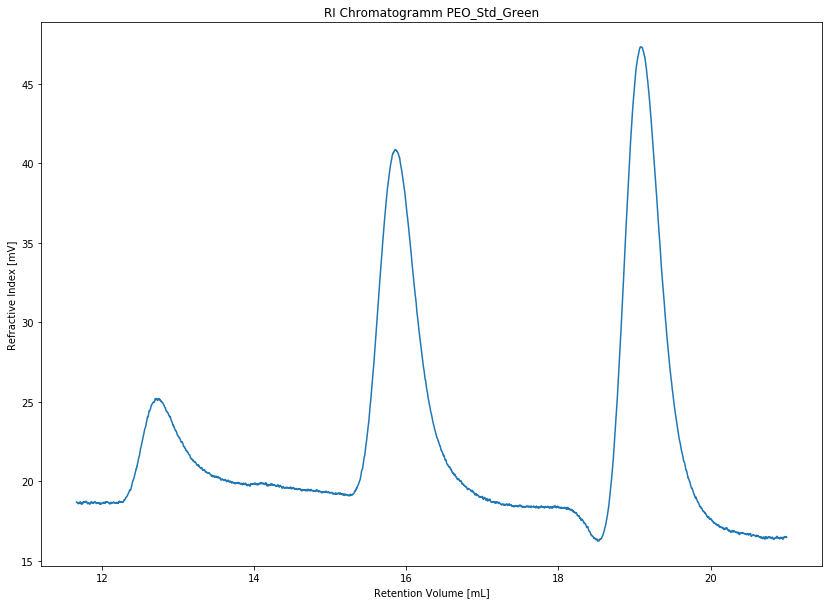

In [5]:
plt.rcParams["figure.figsize"]=[14.0,10.0]

plt.plot(volume[5000:9000],ri[5000:9000])
plt.xlabel("Retention Volume [mL]")
plt.ylabel("Refractive Index [mV]")
plt.title("RI Chromatogramm PEO_Std_Green")

In [6]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    
    #try:
    #    window_size = np.abs(np.int(window_size))
    #    order = np.abs(np.int(order))
    #except ValueError, msg:
    #    raise ValueError("window_size and order have to be of type int")
    #if window_size % 2 != 1 or window_size < 1:
    #    raise TypeError("window_size size must be a positive odd number")
    #if window_size < order + 2:
    #    raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [7]:
def baseline(start_values,end_values,volume,intensity,start_index,end_index,zeros):
    
    m = (end_values[1]-start_values[1])/(end_values[0]-start_values[0]) #slope calculation
    t = start_values[1]-m*start_values[0] #intersept calculation
    
    data_points = (end_index-start_index) #data points under peak
    
    array_length = data_points + 2*zeros
    
    y_new = np.zeros(array_length,)   #defining arrays for new peak
    volume_new = np.zeros(array_length,)
    
    for k in np.arange(array_length):
        volume_new[k] = volume[start_index-zeros+k]
        
    for i in np.arange(data_points):
        y_new[i+zeros] = intensity[start_index+i]-(m*volume[start_index+i]+t)
    return y_new, volume_new

In [8]:
def normalization(start_index,end_index,weights,distribution,volume):
    N = np.zeros(len(distribution))
    span = end_index-start_index
    for i in np.arange(span):
        N[i] = (weights[start_index+i]*distribution[start_index+i])
    return 1/np.sum(N)

In [9]:
def molar_weight(start_index,end_index,weights,distribution,normalization,volume):
    
    span = end_index-start_index
    m_pmma = np.zeros(span,)
    
    for i in np.arange(span):
        m_pmma[i] = np.exp(-0.93496597*float(volume[start_index+i])+25.15914953)
    Mw_array = np.zeros(span,)
    Mn_array = np.zeros(span,)
    for i in np.arange(span):
        Mw_array[i] = normalization*weights[start_index+i]*distribution[start_index+i]*m_pmma[i]
        Mn_array[i] = normalization*(weights[start_index+i]*distribution[start_index+i]/m_pmma[i])
    Mw = np.sum(Mw_array)
    Mn = 1/np.sum(Mn_array)
    polydispersity = Mw/Mn
    return print(Mw, Mn, polydispersity)#,m_pmma,Mw_array

In [10]:
def approximation_total(start,end,x_values,y_values,points,G,a,h):
    
    length = int(end-start)
    
    x_new = np.zeros(length,)
    y_new = np.zeros(length,)
    
    volume_new = np.zeros(points,)
    test_volume = np.zeros(points,)
    test_y = np.zeros(points,)
    
    A = np.zeros([length,points])
    
    span = (x_values[end]-x_values[start])*0.5
    summ = (x_values[end]+x_values[start])*0.5
    
    for i in np.arange(length):
        new = start + i
        x_new[i] = x_values[new]
        y_new[i] = y_values[new]
        
    for p in np.arange(points):
        
        volume_new[p] = span*a[p]-summ
        
        
        
    for k in np.arange(length):
       
        for n in np.arange(points):
            
        
            A[k,n] = span*np.sqrt(h/np.pi)*G[n]*np.exp(-h*np.power((x_new[k]-span*a[n]+summ),2.))
    
         
    
    return  A, x_new, y_new, volume_new, np.array([span,summ])

In [11]:
ri_array = np.array(ri)
ri_filtered = savitzky_golay(ri_array,window_size=200, order = 2)
start_values= np.array([volume[5220],ri_filtered[5220]])
end_values = np.array([volume[6000],ri_filtered[6000]])
ri_filtered_new, volume_new = baseline(start_values, end_values, volume, ri_filtered, 5220 ,6000, 500)

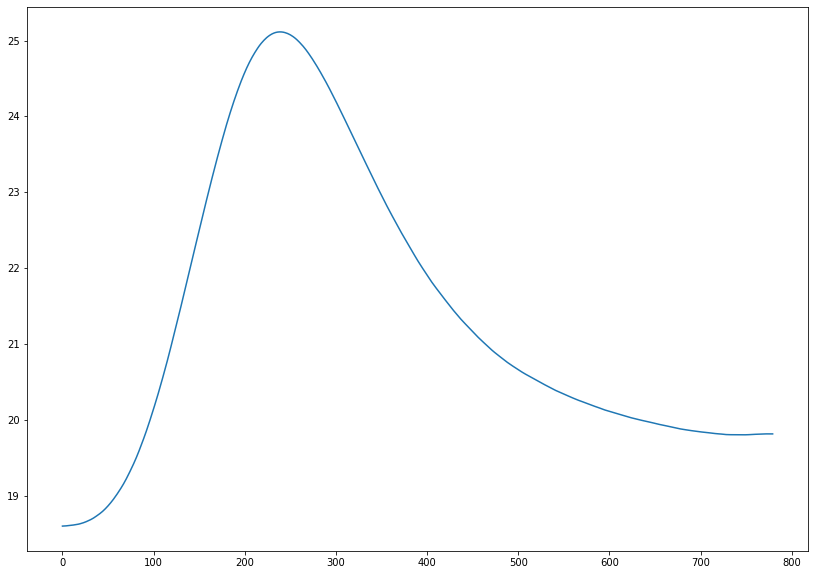

In [12]:
plt.plot(ri_filtered[5220:6000])


In [13]:
np.amax(ri_filtered_new) #find the maximum of the peak
print(np.where(ri_filtered_new == np.amax(ri_filtered_new)))
print(volume_new[736]) #find the volume at the maximum

volume_corrected = volume_new - volume_new[np.where(ri_filtered_new == np.amax(ri_filtered_new))] #correct the peak to be zero at the maximum

(array([736], dtype=int64),)
12.730669975280762


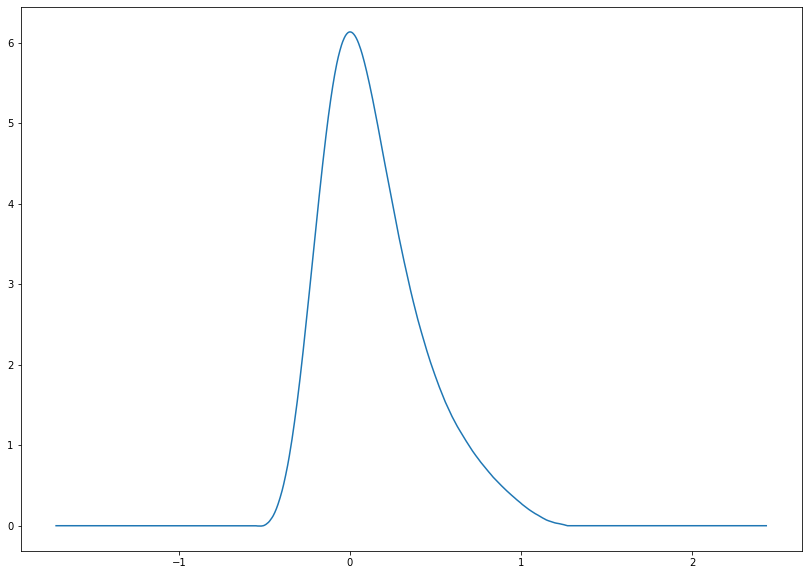

In [14]:
plt.plot(volume_corrected,ri_filtered_new)

In [15]:
print(volume_corrected.shape)

(1780,)


In [16]:
A, x_1, y_1, volume_1,  span = approximation_total(0,1779,volume_corrected,ri_filtered_new,100,weight_100,abscissa_100,400)

In [17]:
F = scipy.optimize.nnls(A,y_1)[0]

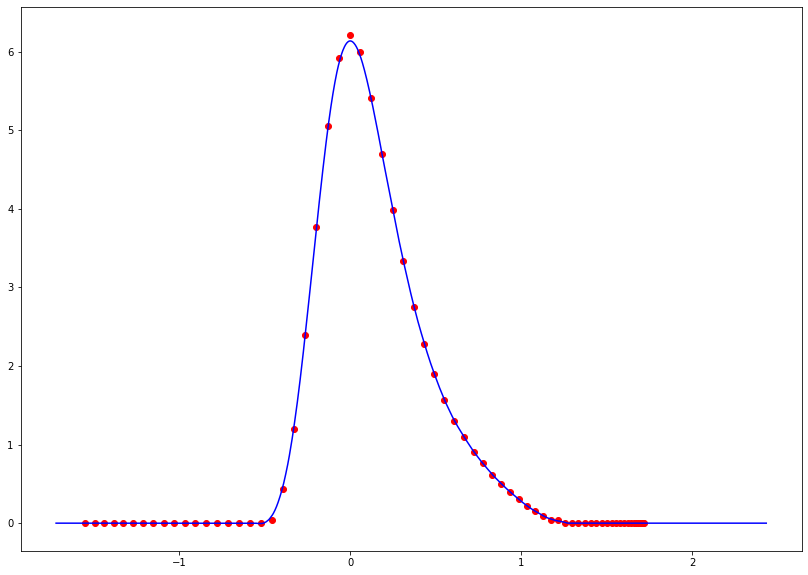

In [18]:
plt.plot(x_1, y_1, color="blue")

plt.scatter(volume_1[30:99], F[30:99], color="red")


In [19]:
volume_recorrected = volume_1 + volume_new[np.where(ri_filtered_new == np.amax(ri_filtered_new))]

In [20]:
N = normalization(30,99,weight_100,F,volume_recorrected)
print(N)

0.527691255184128


In [21]:
molar_weight(30,99,weight_100,F,N,volume_recorrected)




520007.4232471931 482972.13692936907 1.0766820350202524


Text(0, 0.5, 'Intensity')

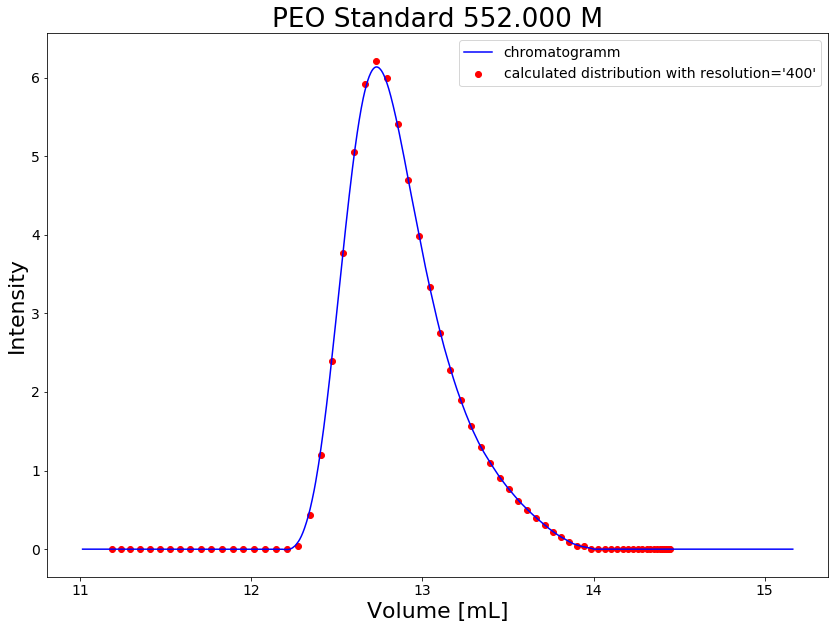

In [29]:
plt.rcParams.update({'font.size': 14})
plt.rc('axes', labelsize= 22)
plt.plot(volume_new, ri_filtered_new , color="blue", label = "chromatogramm")
plt.scatter(volume_recorrected[30:99], F[30:99], color="red",label = "calculated distribution with resolution='400'")
plt.legend()
plt.rcParams.update({'font.size': 22})
plt.title("PEO Standard 552.000 M")
plt.xlabel("Volume [mL]")
plt.ylabel("Intensity")

# Second Peak

In [30]:
start_values_2= np.array([volume[6550],ri_filtered[6550]])
end_values_2 = np.array([volume[7300],ri_filtered[7300]])
ri_filtered_new_2, volume_new_2 = baseline(start_values_2, end_values_2, volume, ri_filtered, 6550 ,7300, 500)

In [31]:
np.amax(ri_filtered_new_2) #find the maximum of the peak
print(np.where(ri_filtered_new_2 == np.amax(ri_filtered_new_2)))
print(volume_new_2[748]) #find the volume at the maximum

volume_corrected_2 = volume_new_2 - volume_new_2[np.where(ri_filtered_new_2 == np.amax(ri_filtered_new_2))] #correct the peak to be zero at the maximum
print(volume_corrected_2.shape)

(array([748], dtype=int64),)
15.862000465393066
(1750,)


In [32]:
B, x_2, y_2, volume_2,  span_2 = approximation_total(0,1749,volume_corrected_2,ri_filtered_new_2,100,weight_100,abscissa_100,400)

In [33]:
F_2 = scipy.optimize.nnls(B,y_2)[0]
volume_recorrected_2 = volume_2 + volume_new_2[np.where(ri_filtered_new_2 == np.amax(ri_filtered_new_2))]

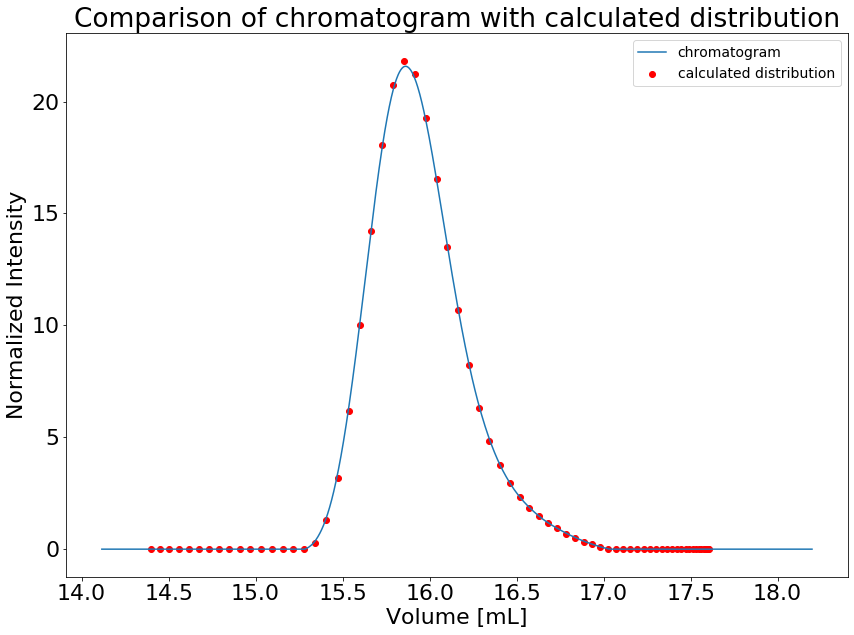

In [36]:
plt.plot(volume_new_2,ri_filtered_new_2, label="chromatogram")
plt.scatter(volume_recorrected_2[30:99],F_2[30:99],color = "red",label = "calculated distribution")
plt.rc('legend', fontsize=14) 
plt.xlabel("Volume [mL]")
plt.ylabel("Normalized Intensity")
plt.title("Comparison of chromatogram with calculated distribution")
plt.legend()

#plt.plot(volume_new,ri_filtered_new)
#plt.scatter(volume_recorrected[30:99],F[30:99])

In [211]:

N_2 = normalization(30, 99, weight_100, F_2, volume_recorrected_2)
print(N_2)
molar_weight(30, 99, weight_100, F_2, N_2, volume_recorrected_2)

0.1566346090650869
29281.765694421585 27501.10304581676 1.0647487719179207


# Third Peak



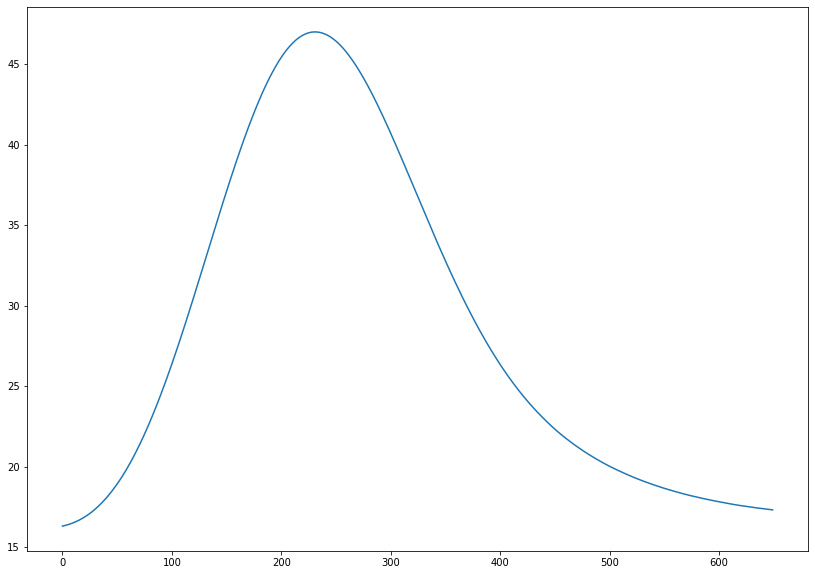

In [212]:
plt.plot(ri_filtered[7950:8600])

In [213]:
start_values_3= np.array([volume[7950],ri_filtered[7950]])
end_values_3 = np.array([volume[8600],ri_filtered[8600]])
ri_filtered_new_3, volume_new_3 = baseline(start_values_3, end_values_3, volume, ri_filtered, 7950 ,8600, 500)

In [214]:
np.amax(ri_filtered_new_3) #find the maximum of the peak
print(np.where(ri_filtered_new_3 == np.amax(ri_filtered_new_3)))
print(volume_new_3[730]) #find the volume at the maximum

volume_corrected_3 = volume_new_3 - volume_new_3[np.where(ri_filtered_new_3 == np.amax(ri_filtered_new_3))] #correct the peak to be zero at the maximum
print(volume_corrected_3.shape)

(array([730], dtype=int64),)
19.086669921875
(1650,)


In [215]:
C, x_3, y_3, volume_3,  span_3 = approximation_total(0,1649,volume_corrected_3,ri_filtered_new_3,100,weight_100,abscissa_100,1000)

In [216]:
F_3 = scipy.optimize.nnls(C,y_3)[0]
volume_recorrected_3 = volume_3 + volume_new_3[np.where(ri_filtered_new_3 == np.amax(ri_filtered_new_3))]

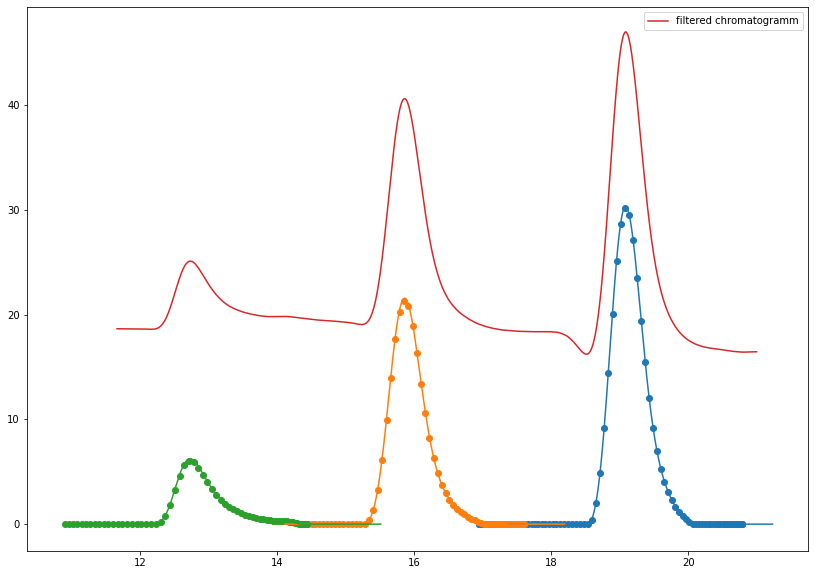

In [217]:
plt.plot(volume_new_3,ri_filtered_new_3)
plt.scatter(volume_recorrected_3,F_3)
plt.plot(volume_new_2,ri_filtered_new_2)
plt.scatter(volume_recorrected_2[30:99],F_2[30:99])
plt.plot(volume_new,ri_filtered_new)
plt.scatter(volume_recorrected[30:99],F[30:99])
plt.plot(volume[5000:9000],ri_filtered[5000:9000], label = "filtered chromatogramm")
plt.legend()

In [218]:
N_3 = normalization(0, 99, weight_100, F_3, volume_recorrected_3)
print(N_3)
molar_weight(0, 99, weight_100, F_3, N_3, volume_recorrected_3)

0.10979600397655424
1447.5355523359294 1375.1389514260663 1.0526467531406811
